In [1]:
import numpy as np

from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl

#mpl.rcParams['figure.figsize'] = [10, 5]
#mpl.rcParams['figure.dpi'] = 300

from tqdne.conf import Config
config = Config()
dataset_path = "/store/sdsc/sd28/wforms_GAN_input_v20220805.h5"
dataset_path

'/store/sdsc/sd28/wforms_GAN_input_v20220805.h5'

In [2]:
import h5py

def load_samples_from_h5_dataset(file_path, n_samples=-1):
    with h5py.File(file_path, 'r', locking=False) as f:
        waveforms = f['waveforms']
        features = np.array([f['hypocentral_distance'], f['is_shallow_crustal'], f['magnitude'], f['vs30']])        
        n_tot_samples = waveforms.shape[0]
        if n_samples > n_tot_samples or n_samples == -1:
            waveforms = waveforms[:]
            features = features[:, 0, :]
        else: 
            samples_indexes = np.sort(np.random.choice(n_tot_samples, n_samples, replace=False))
            waveforms = waveforms[..., samples_indexes]
            features = features[:, 0, samples_indexes]
    waveforms = waveforms.transpose((2, 0, 1))
    features = features.T      
    return waveforms, features    

In [3]:
waveforms, features = load_samples_from_h5_dataset(dataset_path)
waveforms.shape, features.shape

((212598, 3, 5501), (212598, 4))

## Check what is the range of each feature

In [34]:
for i in range(features.shape[-1]):
    print(f'Feature {config.features_keys[i]} --  min: {np.nanmin(features[:, i])}, max: {np.ma.masked_invalid(features[:, i]).max()}, max_inf: {np.max(features[:, i])}, min_inf: {np.min(features[:, i])}')

Feature hypocentral_distance --  min: 3.977979103656216, max: 179.9995778949701, max_inf: 179.9995778949701, min_inf: 3.977979103656216
Feature is_shallow_crustal --  min: 0.0, max: 1.0, max_inf: 1.0, min_inf: 0.0
Feature magnitude --  min: 4.5, max: 9.083505377573305, max_inf: 9.083505377573305, min_inf: 4.5
Feature vs30 --  min: -1.0, max: 2100.000000000001, max_inf: 2100.000000000001, min_inf: -1.0


## Check if there are any `nan` or `inf` values

In [5]:
np.any(np.isnan(waveforms)), np.any(np.isnan(features)), np.any(np.isinf(waveforms)), np.any(np.isinf(features))

(True, False, False, False)

In [6]:
print("Number of shallow crustal envents: ", int(np.sum(features[:, 1])))

Number of shallow crustal envents:  52076


## Visualize the effect of `hypocentral_distance` on waveforms 

In [17]:
time_ax[0], time_ax[-1]

(0.0, 55.0)

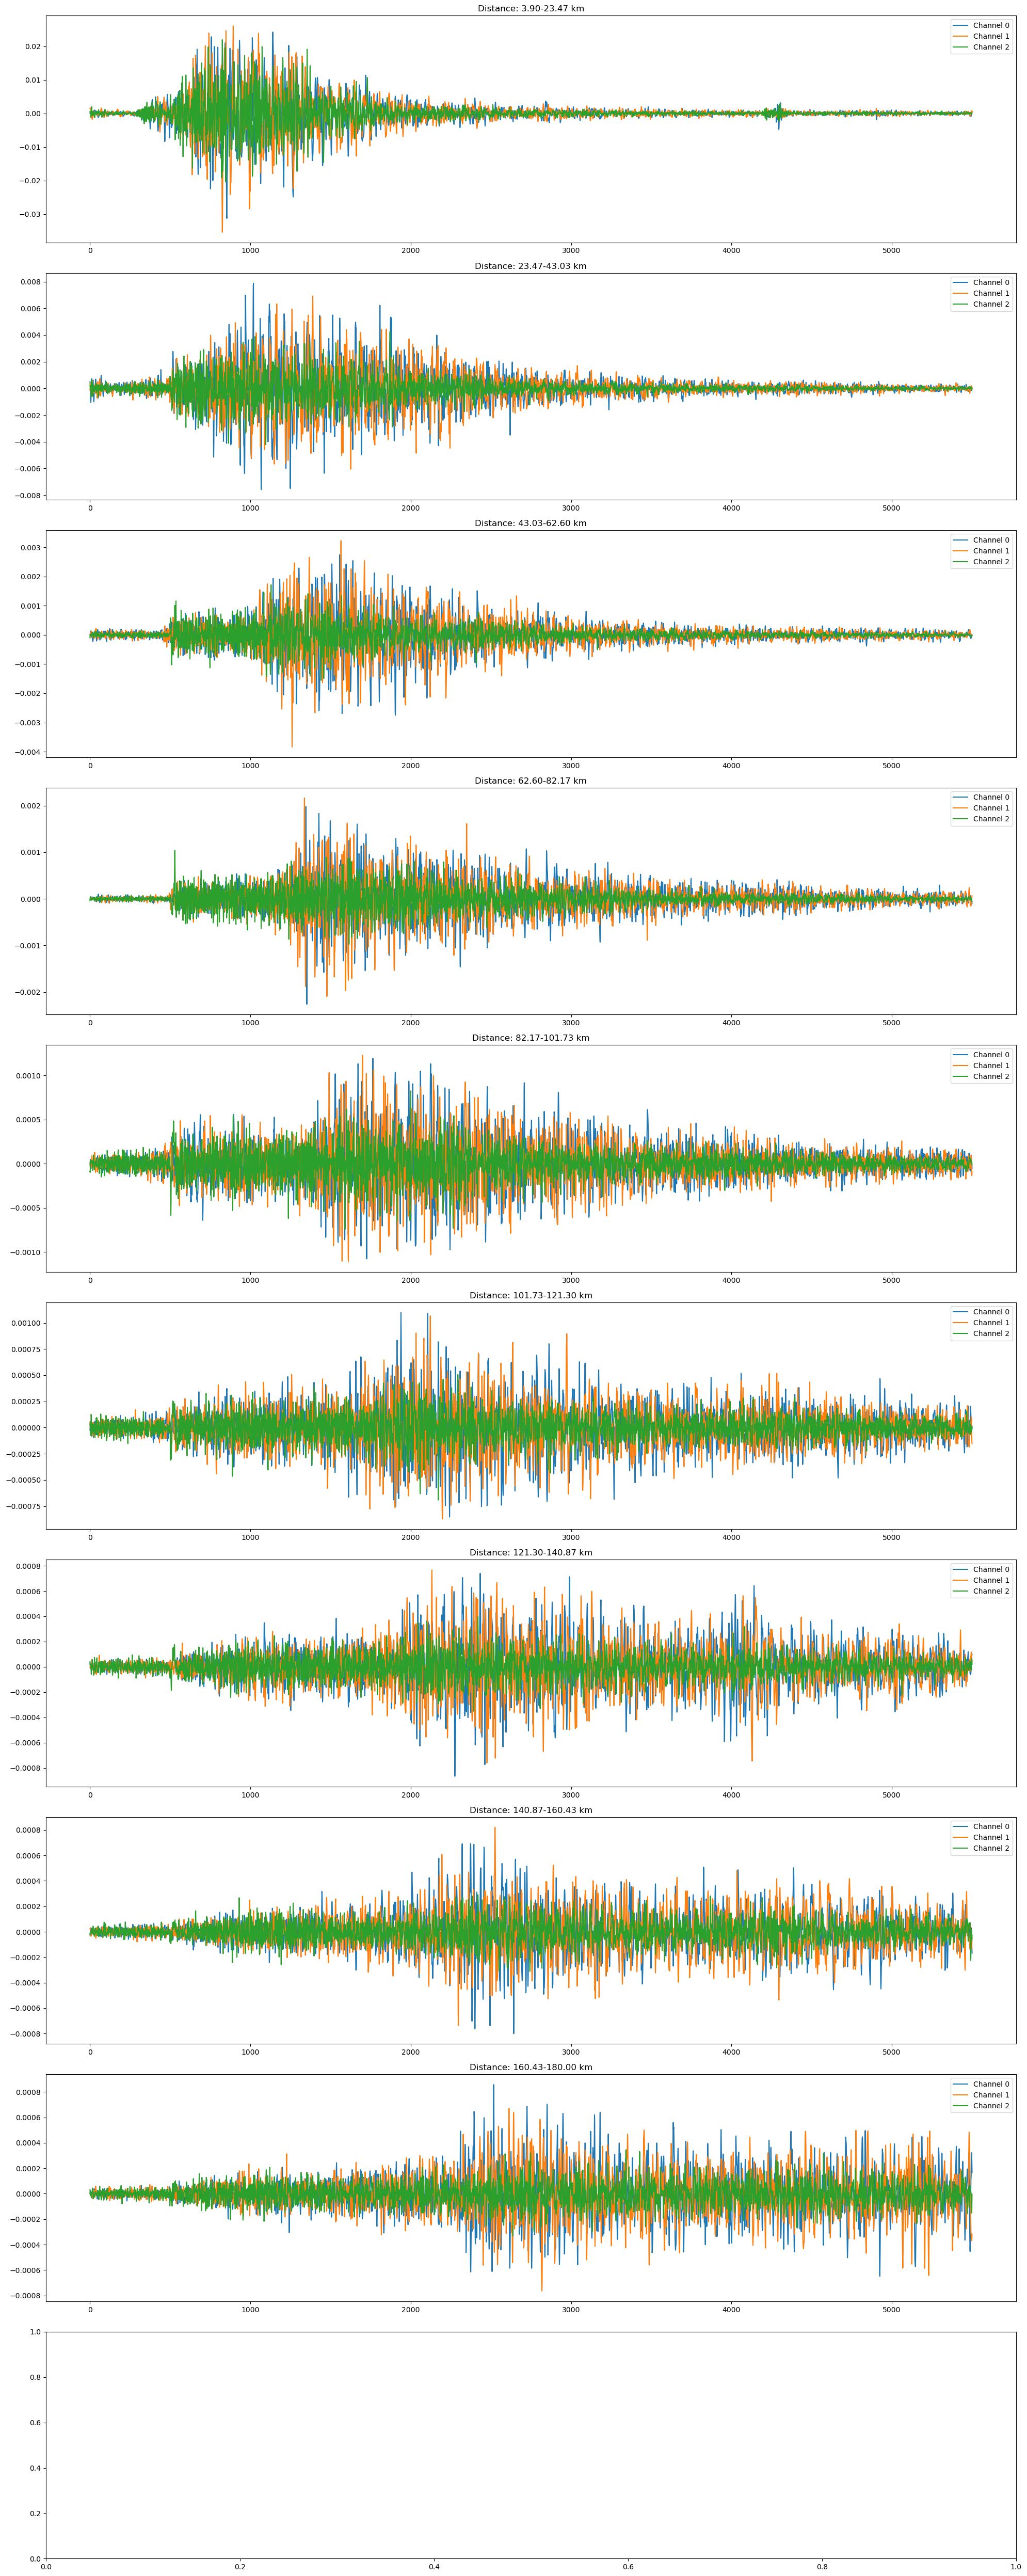

In [4]:
# define distance bins
dist_bins = np.linspace(config.conditional_params_range["hypocentral_distance"][0], config.conditional_params_range["hypocentral_distance"][1], 10)

# divide samples in dist_bins
dist_bins_samples = []
for i in range(len(dist_bins) - 1):
    mask = (features[:, 0] >= dist_bins[i]) & (features[:, 0] < dist_bins[i + 1])
    dist_bins_samples.append(np.nan_to_num((waveforms[mask])))

# plot the mean of each bin
fig, ax = plt.subplots(len(dist_bins), 1, figsize=(20, 5*len(dist_bins)))
time_ax = np.arange(0, waveforms.shape[-1]) / config.fs
for i in range(len(dist_bins_samples)):
    mean_signals = np.mean(dist_bins_samples[i], axis=0)
    for j in range(mean_signals.shape[0]):
        ax[i].plot(mean_signals[j], label=f"Channel {j}")
    ax[i].legend()
    ax[i].set_title(f"Distance: {dist_bins[i]:.2f}-{dist_bins[i+1]:.2f} km")
    fig.tight_layout()

## Check the median spectrum in the fequency domain of all the waveforms

In [6]:
from tqdne.plot import PowerSpectralDensityPlot

# for ch in range(3):
#     psd_plot = PowerSpectralDensityPlot(channel=ch, invert_representation=False)
#     psd_plot.plot(pred=None, target=waveforms[:, ch, :])


# TODO : debug

psd_plot = PowerSpectralDensityPlot(channel=0, invert_representation=False)
psd_plot.plot(preds=None, target=waveforms)

: 

## Bin Stats

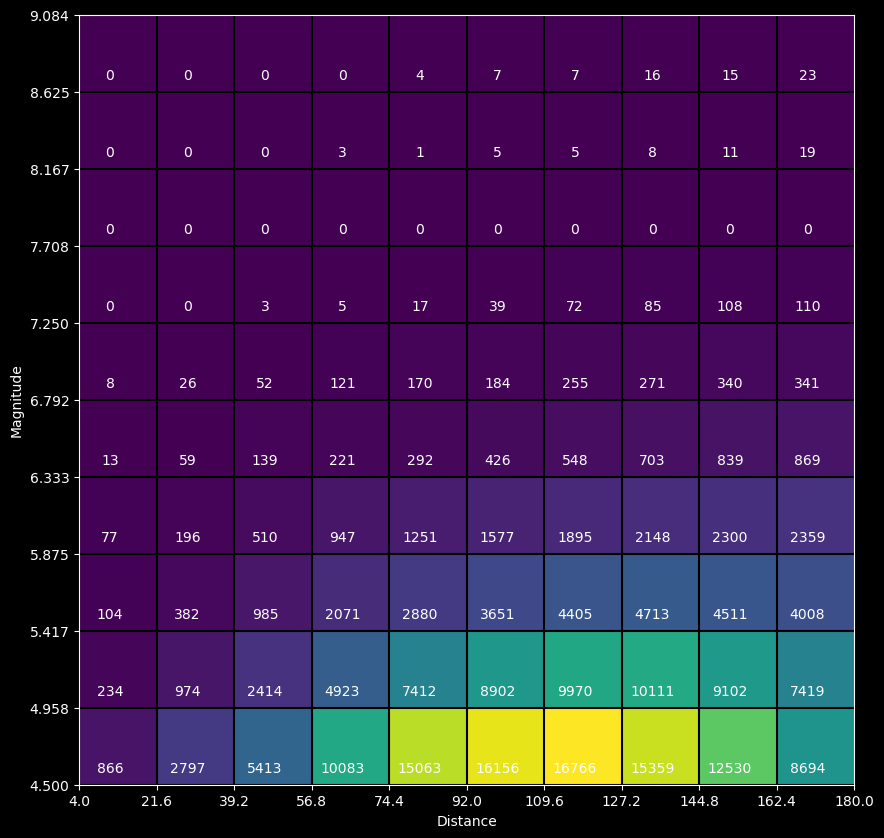

In [54]:
# 2d histogram
fig, ax = plt.subplots(1, figsize=(10, 10))
h = ax.hist2d(features[:, 0], features[:, 2], bins=10, cmap='viridis')

# set x and y ticks
ax.set_xticks(h[1])
ax.set_yticks(h[2])

ax.set_xlabel('Distance')
ax.set_ylabel('Magnitude')
for i in range(10):
    ax.axvline(h[1][i], color='black')
    ax.axhline(h[2][i], color='black')

# annotate with number of samples
for i in range(10):
    for j in range(10):
        ax.text(h[1][i]+7, h[2][j]+.1, f'{int(h[0][i, j])}', ha='center', va='center', color='white')


In [59]:
mag_bins = [(4.5, 4.8), (4.8, 5), (5, 5.5), (5.5, 6.), (6., 6.5), (6.5, 9.1)]
dist_bins = [(0, 50), (50, 100), (100, 150), (150, 200)]

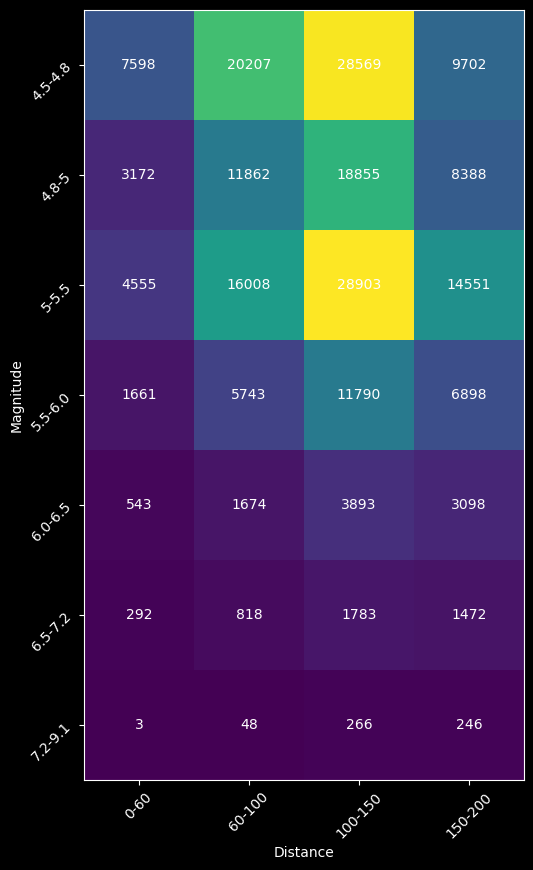

In [60]:
# find number of samples in each bin
n_samples = np.zeros((len(mag_bins), len(dist_bins)))
for i, (mag_min, mag_max) in enumerate(mag_bins):
    for j, (dist_min, dist_max) in enumerate(dist_bins):
        n_samples[i, j] = np.sum((features[:, 0] >= dist_min) & (features[:, 0] < dist_max) & (features[:, 2] >= mag_min) & (features[:, 2] < mag_max))

# plot number of samples in each bin, with annotations and with bin labels as ticks
fig, ax = plt.subplots(1, figsize=(10, 10))
h = ax.imshow(n_samples, cmap='viridis')
ax.set_xlabel('Distance')
ax.set_ylabel('Magnitude')
ax.set_xticks(np.arange(len(dist_bins)))
ax.set_xticklabels([f'{dist_min}-{dist_max}' for dist_min, dist_max in dist_bins], rotation=45)
ax.set_yticks(np.arange(len(mag_bins)))
ax.set_yticklabels([f'{mag_min}-{mag_max}' for mag_min, mag_max in mag_bins], rotation=45)
for i in range(len(mag_bins)):
    for j in range(len(dist_bins)):
        ax.text(j, i, f'{int(n_samples[i, j])}', ha='center', va='center', color='white')
ax.set_title('Number of samples in each bin - entire dataset')        



Check if the train and test distribution matches the one of the entire dataset

In [61]:
from tqdne.dataset import SampleDataset

train_dataset = SampleDataset(Path(config.datasetdir / config.data_train), mag_bins=mag_bins, dist_bins=dist_bins)
test_dataset = SampleDataset(Path(config.datasetdir / config.data_test), mag_bins=mag_bins, dist_bins=dist_bins)

Text(0.5, 1.0, 'Number of samples in each distance-magnitude bin - Train dataset')

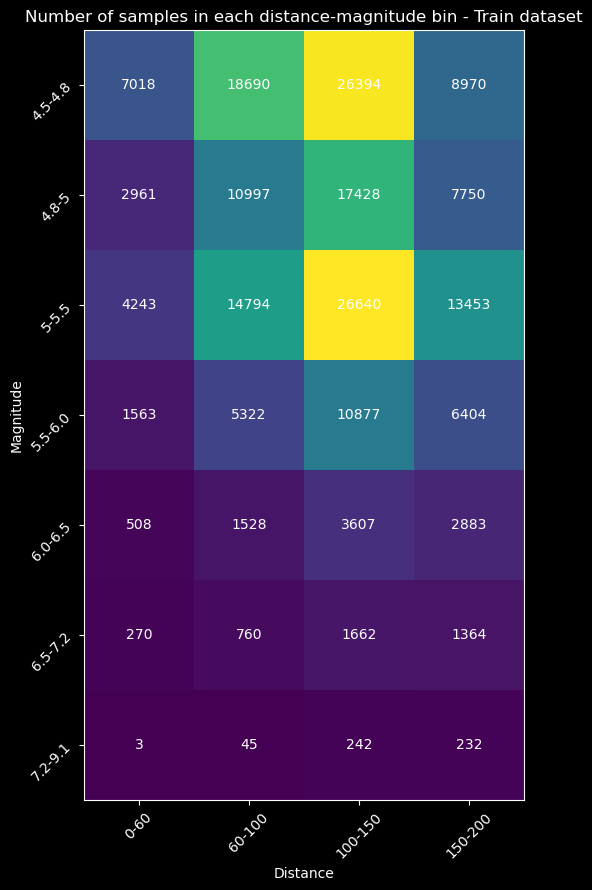

In [62]:
# find number of samples in each bin
features = train_dataset.features

n_samples = np.zeros((len(mag_bins), len(dist_bins)))
for i, (mag_min, mag_max) in enumerate(mag_bins):
    for j, (dist_min, dist_max) in enumerate(dist_bins):
        n_samples[i, j] = np.sum((features[:, 0] >= dist_min) & (features[:, 0] < dist_max) & (features[:, 2] >= mag_min) & (features[:, 2] < mag_max))

# plot number of samples in each bin, with annotations and with bin labels as ticks
fig, ax = plt.subplots(1, figsize=(10, 10))
h = ax.imshow(n_samples, cmap='viridis')
ax.set_xlabel('Distance')
ax.set_ylabel('Magnitude')
ax.set_xticks(np.arange(len(dist_bins)))
ax.set_xticklabels([f'{dist_min}-{dist_max}' for dist_min, dist_max in dist_bins], rotation=45)
ax.set_yticks(np.arange(len(mag_bins)))
ax.set_yticklabels([f'{mag_min}-{mag_max}' for mag_min, mag_max in mag_bins], rotation=45)
for i in range(len(mag_bins)):
    for j in range(len(dist_bins)):
        ax.text(j, i, f'{int(n_samples[i, j])}', ha='center', va='center', color='white')
ax.set_title('Number of samples in each bin - Train dataset')   

Text(0.5, 1.0, 'Number of samples in each distance-magnitude bin - Test dataset')

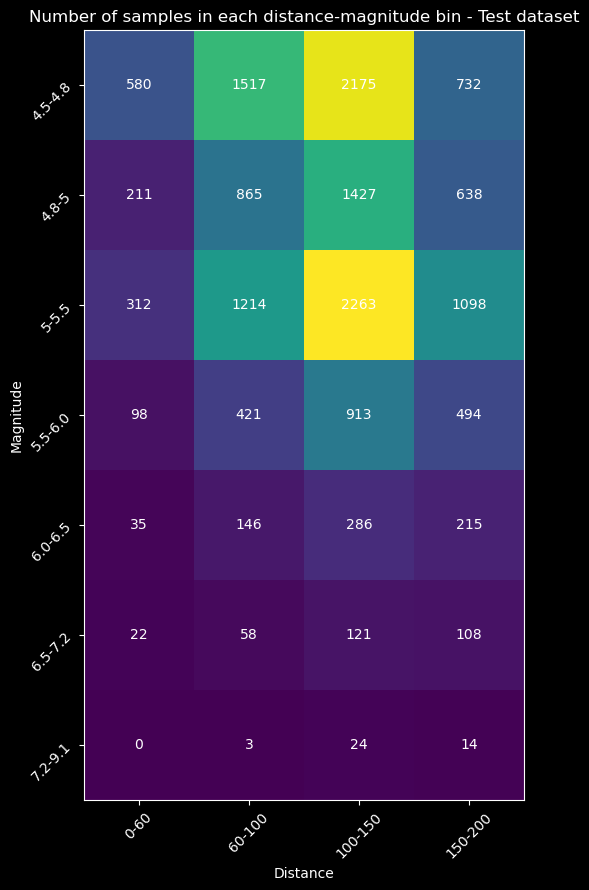

In [63]:
# find number of samples in each bin
features = test_dataset.features

n_samples = np.zeros((len(mag_bins), len(dist_bins)))
for i, (mag_min, mag_max) in enumerate(mag_bins):
    for j, (dist_min, dist_max) in enumerate(dist_bins):
        n_samples[i, j] = np.sum((features[:, 0] >= dist_min) & (features[:, 0] < dist_max) & (features[:, 2] >= mag_min) & (features[:, 2] < mag_max))

# plot number of samples in each bin, with annotations and with bin labels as ticks
fig, ax = plt.subplots(1, figsize=(10, 10))
h = ax.imshow(n_samples, cmap='viridis')
ax.set_xlabel('Distance')
ax.set_ylabel('Magnitude')
ax.set_xticks(np.arange(len(dist_bins)))
ax.set_xticklabels([f'{dist_min}-{dist_max}' for dist_min, dist_max in dist_bins], rotation=45)
ax.set_yticks(np.arange(len(mag_bins)))
ax.set_yticklabels([f'{mag_min}-{mag_max}' for mag_min, mag_max in mag_bins], rotation=45)
for i in range(len(mag_bins)):
    for j in range(len(dist_bins)):
        ax.text(j, i, f'{int(n_samples[i, j])}', ha='center', va='center', color='white')
ax.set_title('Number of samples in each bin - Test dataset')   

## Compute statistics of the training set

In [ ]:
# TODO upload only the train dataset

In [ ]:
n = waveforms.shape[-1]
waveforms = np.nan_to_num(waveforms, nan=0)

mean_signal = np.mean(waveforms, axis=2)
std_dev_signal = np.std(waveforms, axis=2)
max_signal = np.max(waveforms, axis=2)
min_signal = np.min(waveforms, axis=2)

mean = np.mean(waveforms, axis=(1,2))
std = np.std(waveforms, axis=(1,2))
max = np.max(waveforms, axis=(1,2))
min = np.min(waveforms, axis=(1,2))

n, mean_signal.shape, std_dev_signal.shape, max_signal.shape, min_signal.shape, mean.shape, std.shape, max.shape, min.shape

(196608, (3, 5501), (3, 5501), (3, 5501), (3, 5501), (3,), (3,), (3,), (3,))

In [ ]:
num_channels = waveforms.shape[0]
signal_statistics = {}
for i in range(num_channels):
    signal_statistics[f'ch{i+1}'] = {'mean_signal': mean_signal[i], 'std_dev_signal': std_dev_signal[i], 'max_signal': max_signal[i], 'min_signal': min_signal[i], 'mean': mean[i], 'std_dev': std[i], 'max': max[i], 'min': min[i]}

signal_statistics['ch1']['mean_signal'].shape, signal_statistics['ch1']['std_dev_signal'].shape, signal_statistics['ch1']['max_signal'].shape, signal_statistics['ch1']['min_signal'].shape, signal_statistics['ch1']['mean'], signal_statistics['ch1']['std_dev'], signal_statistics['ch1']['max'], signal_statistics['ch1']['min']

((5501,),
 (5501,),
 (5501,),
 (5501,),
 3.1589977e-08,
 0.0417644,
 18.22163,
 -15.233168)

In [ ]:
import pickle

with open('signal_statistics.pkl', 'wb') as f:
    pickle.dump(signal_statistics, f)